In [94]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks, medfilt, savgol_filter
from astropy import units as u
from scipy.ndimage.interpolation import rotate
from specutils import Spectrum1D
import pandas as pd
from scipy import optimize

In [95]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def gaussian(x,amplitude,mean,stdev):
    return amplitude*np.exp(-((x-mean)/4/stdev)**2)

# ^ ^ Функнция, която принтва името на променлива ^ ^ # 
def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def imshow(im):
    plt.figure(figsize=(10, 5))
    plt.imshow(im, vmax=np.mean(im)+np.std(im), vmin = np.mean(im)- np.std(im),cmap='gray')
    plt.title(namestr(im, globals()))
    plt.colorbar()
    
    # ^ ^ Функнция, която принтва името на променлива ^ ^ #
def percent_filter(spectra,de,percent=0.5):
    d=de//2
    spec=spectra
    for j in range(d+1,len(spec)-d):
        av=np.average(spectra[j-d:j+d])
        cut=spectra[j-d-1:j+d]
        for k in range(de):
            if cut[k]>(1. + percent) * av or cut[k] < percent*av:
                cut[k]=av
        spec[j-d-1:j+d]=cut
    return spec


def imcombine_median(im1, im2, im3):
    masterIm = np.median(np.dstack((im1, im2, im3)), axis = 2)
    return masterIm

    # ^ ^ Функция, която комбинира медианно три кадъра  ^ ^ #

def sliceIndices(rows):
    fwhm = peak_widths(rows, [np.argmax(rows)], rel_height=0.9)
    start = int(np.round(fwhm[2]))
#    print(start)
    end = int(np.round(fwhm[3]))
#    print(end)
    return (start, end)

    # ^ ^ Функция, която връща двойка числа, отговарящи на двете крила около пик 


def PolyEval(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """
    o = len(coeffs)
    #print(f'# This is a polynomial of order {o}.')
    y = 0
    for i in range(o):
        y += coeffs[i]*x**(o-1-i)
    return y



def find_nearest(arre, value):
    arre = np. asarray(arre)
    idx = (np. abs(arre - value)). argmin()
    return arre[idx]

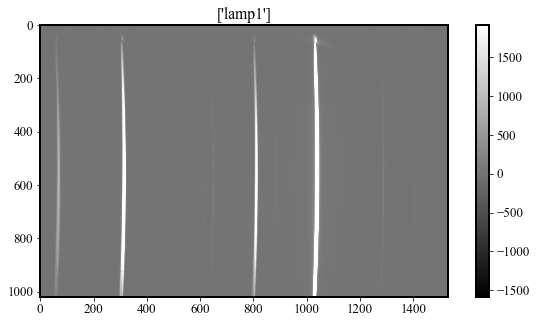

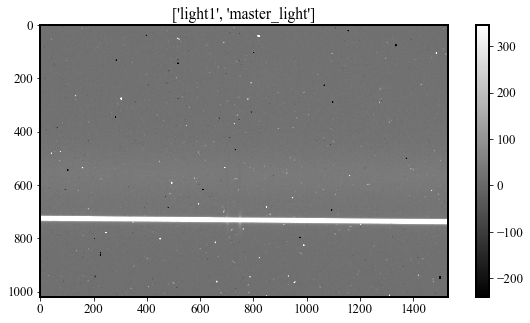

In [104]:
#######################################

dark1 = fits.getdata('Dark-5s-001.FIT')
dark2 = fits.getdata('Dark-5s-002.FIT')
dark3 = fits.getdata('Dark-5s-003.FIT')


master_dark_15s = imcombine_median(dark1, dark2, dark3)
#######################################

lamp1_1 = fits.getdata('lamp3-5s-001.FIT')
lamp1_2 = fits.getdata('lamp3-5s-002.FIT')
lamp1_3 = fits.getdata('lamp3-5s-003.FIT')


lamp1 = imcombine_median(lamp1_1, lamp1_2, lamp1_3) - master_dark_15s

imshow(lamp1)


########################################

dark1 = fits.getdata('Dark-1800s-001.FIT')
dark2 = fits.getdata('Dark-1800s-002.FIT')
dark3 = fits.getdata('Dark-1800s-003.FIT')

master_dark_1800s = imcombine_median(dark1, dark2, dark3)


#######################################

light1 = fits.getdata('Io-1800s-2.FIT') - master_dark_1800s
#light2 = fits.getdata('Jupyter-60s-002.FIT') - master_dark_900s
#light3 = fits.getdata('Jupyter-60s-003.FIT') - master_dark_900s
#light4 = fits.getdata('Jupyter-60s-004.FIT') - master_dark_900s

#master_light = imcombine_median(light1, light2, light3) + imcombine_median(light2, light3, light4) + imcombine_median(light3, light4, light1) + imcombine_median(light4, light1, light2)
master_light = light1
#master_light1 = light1
#master_light2 = light2
#master_light3 = light3

########################################

imshow(master_light)


[   5    6    7   46   80  233  254  286  287  306  307  458  499  600
  664  696  795  817  818  819  820  961  996 1166 1319 1487 1506 1507
 1535 1536]
[  0.         210.74707128 505.04859201]


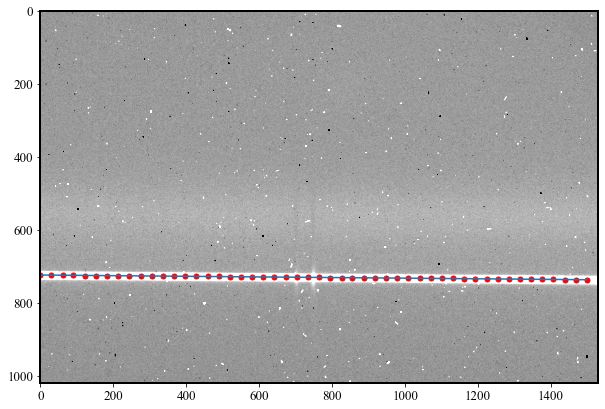

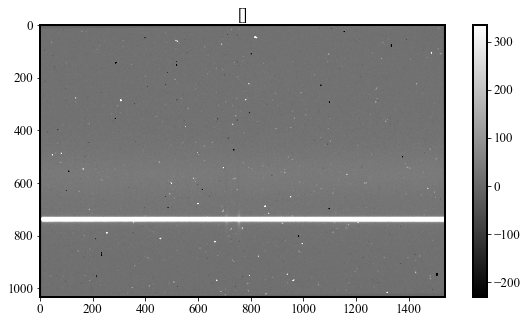

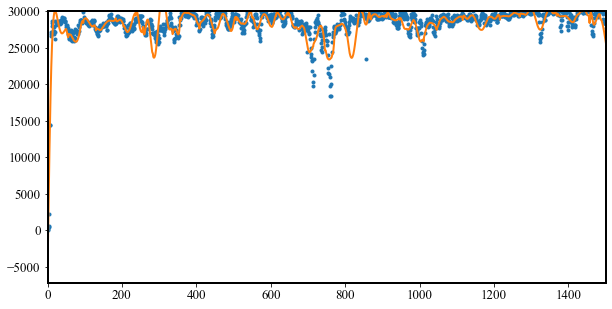

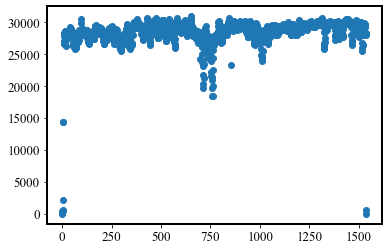

In [105]:
def makeSpectra(master_light):
    spec_col = []
    spec_row = []
    number_points= 50



    for i in range(number_points):

        medcol = np.median([
                            master_light[:, int((len(master_light[0])*i/number_points))], 
                            master_light[:, int((len(master_light[0])*i/number_points)+1)],
                            master_light[:, int((len(master_light[0])*i/number_points)-1)],
                            master_light[:, int((len(master_light[0])*i/number_points)+2)],
                            master_light[:, int((len(master_light[0])*i/number_points)-2)]
                                                                        ], axis=0) 
        
        
        mean = sliceIndices(medcol)
        spec_row = np.append(spec_row, np.mean(mean))
        spec_col = np.append(spec_col, int((len(master_light[0])*i/number_points)))


        
    coefs = np.polyfit(spec_col,spec_row, 1)


    plt.figure(figsize=(10,10))
    plt.plot(spec_col, spec_row, 'o', markersize=5, color='r')
    plt.imshow(master_light, vmin=-100, vmax=100, cmap='gray')
    plt.plot(spec_col, [PolyEval(x, coefs) for x in spec_col])

    angle = np.arctan(coefs[0])*180/np.pi
    ml_rot = rotate(master_light, angle)


    imshow(ml_rot)
    col_ind,spectra=np.zeros((len(ml_rot[0]),2)),np.zeros(len(ml_rot[0]))
    len_rowsa=len(ml_rot[0])
    for u in range(1,len_rowsa-1):
        col_ind[u]=sliceIndices(ml_rot[:,u])

        spectra[u]=np.sum(ml_rot[int(col_ind[u][0]):int(col_ind[u][1]),u])
    
    spec_fit = savgol_filter(spectra, 101, 8)
    outliers = np.where(abs(spec_fit - spectra) > 10000)[0]
    for i in outliers:
        spectra[i] = np.median(np.concatenate((spectra[i - 5 : i - 1], spectra[i + 1 : i + 5])))

    
    
    plt.figure(figsize = (10, 5))    
    plt.plot(spectra, 'o', markersize = 3)
    plt.plot(spec_fit, '-', lw=2)
    plt.axis(xmin = 0, xmax = 1500, ymax = 30000)


    #spectra = (spectra, sorted(outliers, reverse=True))



    plt.figure()

    # spectra = medfilt(spectra, 5)
    plt.plot(spectra, 'o')

    print(outliers)

    print(spectra[spectra <  20000][0:3])

    np.where(spectra <  21000)[0]
    return (spectra,angle)

#spec1, angle = makeSpectra(master_light1)
#spec2, angle = makeSpectra(master_light2)
#spec3, angle = makeSpectra(master_light3)

spectra, angle = makeSpectra(master_light)


[ 320  815 1042]
[322, 811, 1046]
[-1.03615492e-01  6.24990539e+03]
6249.905385917543 6090.441143245993


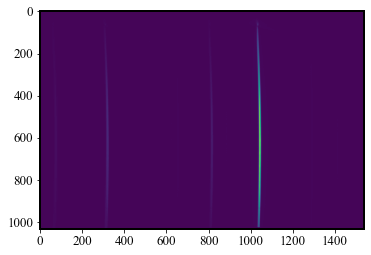

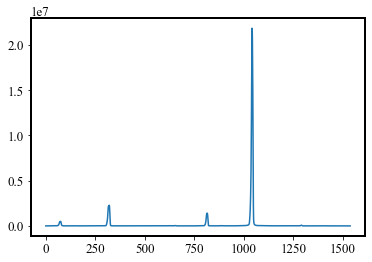

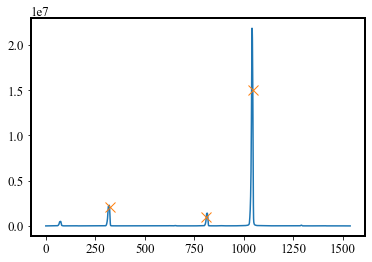

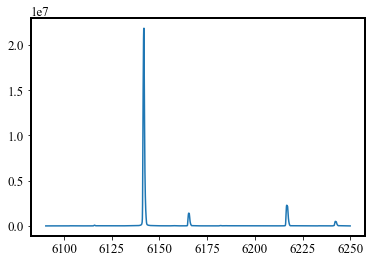

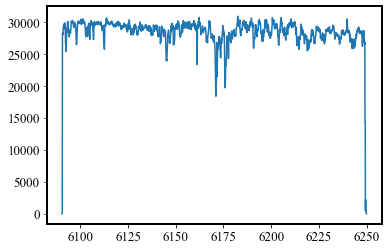

In [106]:
lampIm = rotate(lamp1, angle)

plt.figure()
plt.imshow(lampIm)

# ^ ^ Завъртян кадър на лампа ^ ^ #

lamp_threshold = 500000
#lampLambdasHa = [6598.953, 6532.882, 6506.528]6266.495, 
lampLambdas = [6217.281, 6163.594, 6143.063]

lampColSums = np.sum(lampIm, axis = 0)
#print(lampColSums[peaks[0]-med_len:peaks[0]+med_len])
#print(find_nearest(lampColSums,np.median(lampColSums[peaks[0]-med_len:peaks[0]+med_len])))

#print(np.where(lampColSums==(np.median(lampColSums[peaks[0]-med_len:peaks[0]+med_len]))),"sadsa")

plt.figure()
plt.plot(lampColSums)

peaks, _ = find_peaks(lampColSums, lamp_threshold, distance = 50)
med_len=7
print(peaks)
peaks=[np.where(lampColSums == find_nearest(lampColSums[peaks[0]-med_len:peaks[0]+med_len],np.median(lampColSums[peaks[0]-med_len:peaks[0]+med_len])))[0] ,np.where(lampColSums==find_nearest(lampColSums[peaks[1]-med_len:peaks[1]+med_len],np.median(lampColSums[peaks[1]-med_len:peaks[1]+med_len])))[0],np.where(lampColSums==find_nearest(lampColSums[peaks[2]-med_len:peaks[2]+med_len],np.median(lampColSums[peaks[2]-med_len:peaks[2]+med_len])))[0]]
peaks=[int(peaks[0]),int(peaks[1]),int(peaks[2])]
print(peaks)
# ^ ^ Намиране на пиковете на сумите по колони ^ ^ #

plt.figure()
plt.plot(lampColSums)
plt.plot( peaks, lampColSums[peaks], 'x', markersize = 10)
peaks


imageLen = len(lampColSums)

def calibrate(peaks, lengths, imageSize):
  z = np.polyfit(peaks,lengths, 1)
  #plt.plot( peaks, lengths, 'x', markersize = 10)
  #plt.plot([PolyEval(i, z) for i in range(1530)])
  print(z)
  return (PolyEval(0, z), PolyEval(imageLen, z))
  

startLambda, endLambda = calibrate(peaks, lampLambdas, imageLen)
print(startLambda,endLambda)
lambdas = np.linspace(startLambda, endLambda, imageLen)


plt.figure()
plt.plot(lambdas, lampColSums)

# ^ ^ Фитиране на трите ламбди през права, намиране на стойностите отговарящи на съответните пиксели ^ ^ # 
plt.figure()
plt.plot(lambdas, spectra)

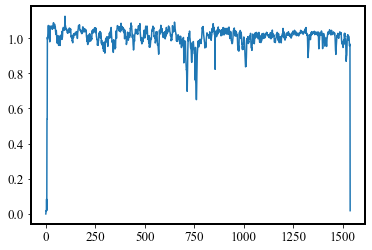

In [107]:
c = savgol_filter(spectra, 1201 , 2)

spectra_fitted = [spectra[i] / c[i] for i in np.arange(0, imageLen-1, 1)]

plt.plot(spectra_fitted)

<ipython-input-111-5d2518a728a9>:18: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']
No handles with labels found to put in legend.


      Lambda      Flux
0         30  1.068769
1         31  1.067208
2         32  1.056268
3         33  1.051192
4         34  1.063000
...      ...       ...
1493    1523  1.012153
1494    1524  1.008365
1495    1525  1.020042
1496    1526  0.988617
1497    1527  0.996088

[1498 rows x 2 columns]


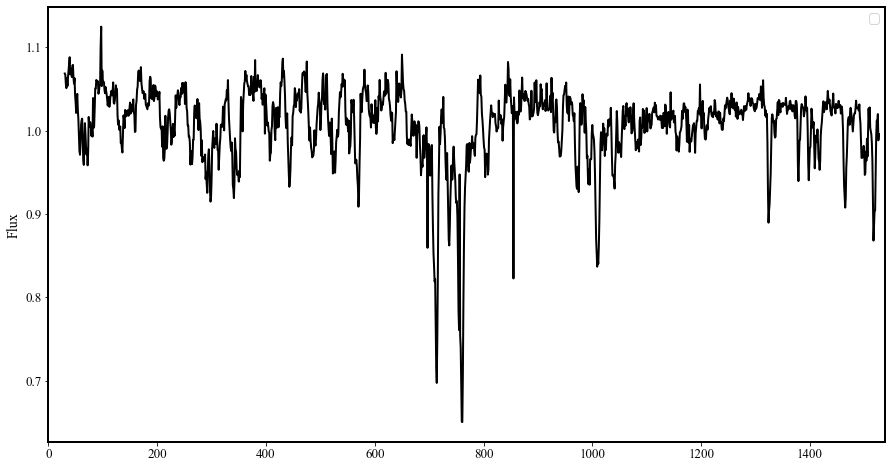

In [111]:
from matplotlib import rc, rcParams
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec


from matplotlib import rc

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 13

rc('text', usetex=False)
rc('axes', linewidth=2)
rc('font')


rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']

lambdas = np.arange(0, imageLen, 1)

spectrum = zip(lambdas[30: -10], spectra_fitted[30 : -10])
dfa = pd.DataFrame(spectrum, columns = ['Lambda', 'Flux'])
dfa.dropna(subset = ["Flux"], inplace=True) 


plt.figure(figsize = (15,8))


plt.plot(dfa['Lambda'], dfa['Flux'], '-',c='k', lw=2)
plt.axis(xmin = 0, xmax = imageLen)
plt.ylabel('Flux', fontsize=14)
#plt.xlabel('$\lambda$ [$\AA$]', fontsize=14)
plt.legend()


print(dfa)
dfa.to_csv('Io-spectrum.csv')


No handles with labels found to put in legend.


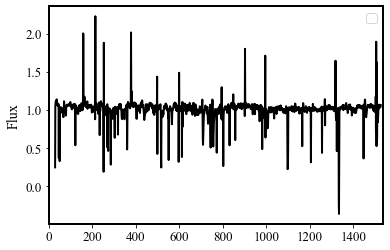

In [110]:
plt.plot(df['Lambda'], df['Flux'], '-',c='k', lw=2)
plt.axis(xmin = 0, xmax = imageLen)
plt.ylabel('Flux', fontsize=14)
#plt.xlabel('$\lambda$ [$\AA$]', fontsize=14)
plt.legend()